# QOSF Mentorship Program Screening Task 1: less than k

Task 1 of the qosf mentorship program screening is given as below:

_Given a positive integer "k" and a list of integer numbers, look for the numbers within the list, that are less than k. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case_

References:
- [1] Deutsch, David, and Richard Jozsa. &quot;Rapid solution of problems by quantum
computation.&quot; Proceedings of the Royal Society of London. Series A: Mathematical and
Physical Sciences 439.1907 (1992): 553-558.
- [2] Bernstein, Ethan, and Umesh Vazirani. &quot;Quantum complexity theory.&quot; SIAM Journal
on computing 26.5 (1997): 1411-1473.
- [3] Grover, Lov K. , &quot;A fast quantum mechanical algorithm for database search&quot;,
Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## 1. Introduction
### 1.1 Overview of Strategy
The idea is to build a quantum circuit that can compare two integer values and tell us whether one is smaller than the other. This circuit can then be used repeatedly to loop through the list of numbers that is of interest, and print all the numbers that are smaller than the positive integer "k".

#### 1.1.1 Mathematical Expression of Integer Comparison
To compare two integers, the operation is built upon a bit-by-bit comparison operation.
We start from the most significant digit, and check if one is larger than the other. 
If they are the same, then we move on to the next leading digit and check.
Hence, the comparison formula is given by:

$a<b=(a_0 < b_0) \lor (a_0 = b_0)(a_1 < b_1) \lor (a_0 a_1 = b_0 b_1)(a_2 < b_2) \lor ... \lor (a_0 a_1 ... a_{n-2}=b_0 b_1 ... b_{n-2})(a_{n-1} < b_{n-1})$
                                    , where $a=a_0 a_1 a_2 ...a_{n-1}$ and $b=b_0 b_1 b_2 ... b_{n-1}$

Since the collection of OR conditions cannot happen at the same time, this is equivalent to 
$a<b=(a_0 < b_0) \oplus (a_0 = b_0)(a_1 < b_1) \oplus (a_0 a_1 = b_0 b_1)(a_2 < b_2) \oplus ... \oplus (a_0 a_1 ... a_{n-2}=b_0 b_1 ... b_{n-2})(a_{n-1} < b_{n-1})$

### 1.1.2 Quantum Circuit Structure
#### 1.1.3.1 Bit-comparison unit, $U_<$
The bit comparison unit forms the foundation of the circuit. The unit takes in two bits and one aux bit, and returns the values of $(a_i<b_i)$ and $(a_i=b_i)$.

It has the following structure:

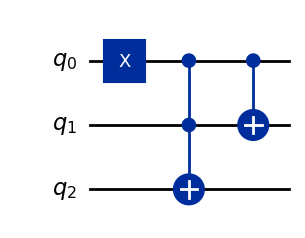

In [2]:
circuit = QuantumCircuit(3)
circuit.x(0)
circuit.ccx(0, 1, 2)
circuit.cx(0, 1)
circuit.draw('mpl')

#### 1.1.3.2 Aux-bit reset unit, $U_0$
Another repeating sub-circuit is the aux-bit reset unit. It is used after the bit-comparison unit to reset the aux-bit to zero, which allows the bit to store new information for $(a_0 a_1 ... a_{i}=b_0 b_1 ... b_{i})$. This will become more clear in the Section 1.1.3.3 when we look at the whole quantum circuit.

This unit has the following structure:


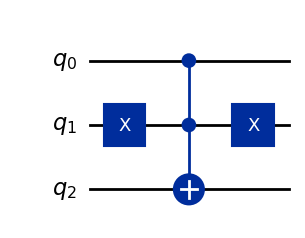

In [3]:
circuit = QuantumCircuit(3)
circuit.x(1)
circuit.ccx(0, 1, 2)
circuit.x(1)
circuit.draw('mpl')

#### 1.1.3.3 Whole circuit
The whole circuit as shown below can be understood as processing the mathematical expression stage-by-stage over the collection of $\oplus$ conditions. After each stage, the final result bit for $a<b$ is always stored on the aux bit 0.

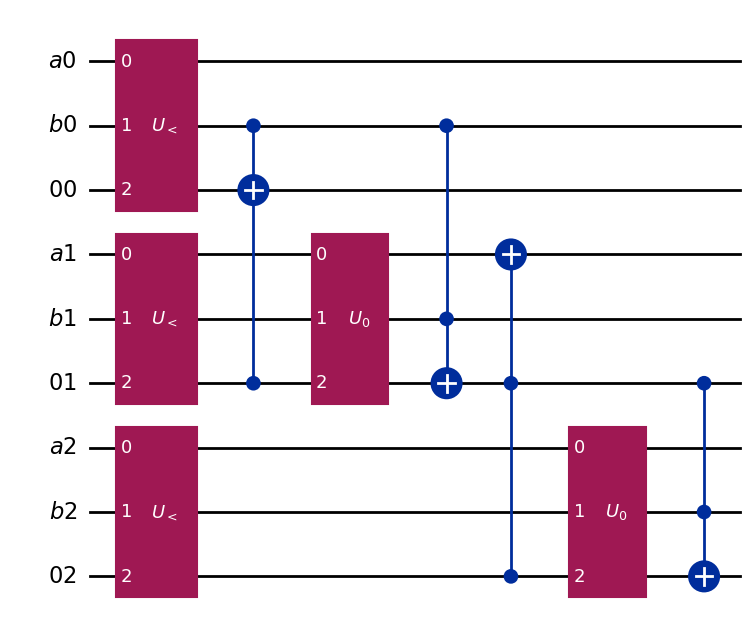

In [4]:
a0_qubit = QuantumRegister(1, 'a0')
b0_qubit = QuantumRegister(1, 'b0')
zero0_qubit = QuantumRegister(1, '00')
a1_qubit = QuantumRegister(1, 'a1')
b1_qubit = QuantumRegister(1, 'b1')
zero1_qubit = QuantumRegister(1, '01')
a2_qubit = QuantumRegister(1, 'a2')
b2_qubit = QuantumRegister(1, 'b2')
zero2_qubit = QuantumRegister(1, '02')


circuit = QuantumCircuit(a0_qubit,b0_qubit,zero0_qubit,a1_qubit,b1_qubit,zero1_qubit,a2_qubit,b2_qubit,zero2_qubit)
ltUnitary = UnitaryGate(random_unitary(8), label=r"   $U_<$   ")
resetUnitary = UnitaryGate(random_unitary(8), label=r"   $U_0$   ")
circuit.append(ltUnitary, [0,1,2])
circuit.append(ltUnitary, [3,4,5])
circuit.append(ltUnitary, [6,7,8])
circuit.ccx(1,5,2)
circuit.append(resetUnitary, [3,4,5])
circuit.ccx(1,4,5)
circuit.ccx(5,8,3)
circuit.append(resetUnitary, [6,7,8])
circuit.ccx(5,7,8)
circuit.draw('mpl')

### 1.2 Layout of study
In Section 2, we will first valid the circuit design with an ideal simulator without any noise. Then we will study the effect of noise to the algorithm in Section 3. Since the quantum circuit fundamentally operates on two integers, we will study the effect of noise on the accuracy of comparing two integers.

## Section 2 Quantum Circuit with Noise-Free Simulator

### Constructing a quantum circuit to compare two integers

In [5]:
def dec_to_bin(num:int, digits:int):
    """
    This function converts the integers from decimal form to binary form, with the specfied number of digits
    num: decimal number to be converted to binary
    digits: number of binary digit (filled with leading zeros)
    """
    if(bin(num)[0]=='-'):
        unsigned=num*-1
        bits = [1-int(bit) for bit in f'{unsigned:0{digits}b}']
        bits.insert(0,0)
    else:
        bits = [int(bit) for bit in f'{num:0{digits}b}']
        bits.insert(0,1)
    return bits
    

def qc_less_than(a:int,b:int):
    """
    This function returns the quantum circuit that takes two signed integers and measures true on the classical register if 'a' is less than 'b'
    a, b: the two integers to be checked
    folding_sf: Scale factor for unitary folding (for noise mitigation)
    idlayer_sf: Scale factor for identity insertion (for noise mitigation)
    """
    # In order to setup the circuit, we need to determine how many qubits are needed, and whether the integers are negative
    n = max(a.bit_length(), b.bit_length())

    # We will use n+1 qubits, where the additional qubit is for taking into account the sign of the integer
    qr_a = QuantumRegister(n+1, name='a')
    qr_b = QuantumRegister(n+1, name='b')
    qr_aux = QuantumRegister(n+1, name='aux')
    cr = ClassicalRegister(1, name='cr')
    qc = QuantumCircuit(qr_a, qr_b, qr_aux, cr)

    # encoding the two integers as binary 
    a_bits = dec_to_bin(a,n)
    b_bits = dec_to_bin(b,n)
        
    # initializing the initial state to represent the two binary numbers 
    for i, bit in enumerate(a_bits):
        if bit == 1:
            qc.x(qr_a[i])
    for i, bit in enumerate(b_bits):
        if bit == 1:
            qc.x(qr_b[i])

    # building the quantum circuit with the quantum gates needed
    def bit_compare(i:int):
        """
        a base quantum circuit unit to compare two bits on the i-th significant digit 
        """
        qc.x(qr_a[i])
        qc.ccx(qr_a[i],qr_b[i],qr_aux[i])
        qc.cx(qr_a[i],qr_b[i])
    
        
    def reset_aux(i:int):
        """
        a base quantum circuit unit to reset the aux bit to 0
        """
        qc.x(qr_b[i])
        qc.ccx(qr_a[i],qr_b[i],qr_aux[i])
        qc.x(qr_b[i])
    
    for i in range(n+1):
        bit_compare(i)
    for i in range(1,n+1):
        if(i==1):
            qc.ccx(qr_b[0],qr_aux[1],qr_aux[0])
        elif(i==2):
            reset_aux(i-1)
            qc.ccx(qr_b[i-2],qr_b[i-1],qr_aux[i-1])
            qc.ccx(qr_aux[i-1],qr_aux[i],qr_aux[0])
        else:
            reset_aux(i-1)
            qc.ccx(qr_aux[i-2],qr_b[i-1],qr_aux[i-1])
            qc.ccx(qr_aux[i-1],qr_aux[i],qr_aux[0])
    
    # measure the aux qubit 0 onto the classical register
    qc.measure(qr_aux[0], cr[0])
    
    #print(qc)
    return qc
    

### High-level end-user code 

In [6]:
def less_than(sim, thres:int, test:int, shots:int=1):
    """
    This function takes two signed integers and returns true if test is less than threshold
    sim: user-defined simulator
    thres: threshold value for test to be less than
    test: integer to be tested
    shots: number of shots
    folding_sf: Scale factor for unitary folding (for noise mitigation)
    idlayer_sf: Scale factor for identity insertion (for noise mitigation)
    """
    circ = qc_less_than(test,thres)
    circ = transpile(circ, sim)
    job = sim.run(circ, shots=shots)
    result = job.result().get_counts()
    
    if '0' not in result:
        return (True,result)
    elif '1' not in result:
        return (False,result)
    elif result['1']>result['0']:
        return (True,result)
    else:
        return (False,result)


In [7]:
def less_than_k(k:int, list_n:list[int]):
    """
    This function takes an integer k and returns all the numbers in a list of integers that are less than k
    k: the threshold integer
    list_n: the list of integers to be filtered
    """
    ans=""
    aersim = AerSimulator()
    for num in list_n:
        flg_lt,_=less_than(aersim,k,num)
        if(flg_lt):
            if(ans==""):
                ans+=str(num)
            else:
                ans+=",{}".format(num)
    return ans

### Validation with Test cases

In [8]:
A = less_than_k(7,[4,9,11,14,1,13,6,15])
print(A)
if(A=='4,1,6'):
    print("It is working!")

4,1,6
It is working!


In [9]:
A = less_than_k(-7,[4,-9,11,-14,-1,0,6,-15]) # The code also works for negative integers!
print(A)
if(A=='-9,-14,-15'):
    print("It is working!")

-9,-14,-15
It is working!


## Section 2 Results with Different Noisy Backends

### 2.1 Fake27QPulseV1

A fake pulse backend with the following characteristics:
- num_qubits: 27
- coupling_map:
```
               06                  17
               ↕                    ↕
00 ↔ 01 ↔ 04 ↔ 07 ↔ 10 ↔ 12 ↔ 15 ↔ 18 ↔ 20 ↔ 23
     ↕                   ↕                    ↕
     02                  13                  24
     ↕                   ↕                    ↕
     03 ↔ 05 ↔ 08 ↔ 11 ↔ 14 ↔ 16 ↔ 19 ↔ 22 ↔ 25 ↔ 26
               ↕                    ↕
               09                  20
```
- basis_gates: ["id", "rz", "sx", "x", "cx", "reset"]


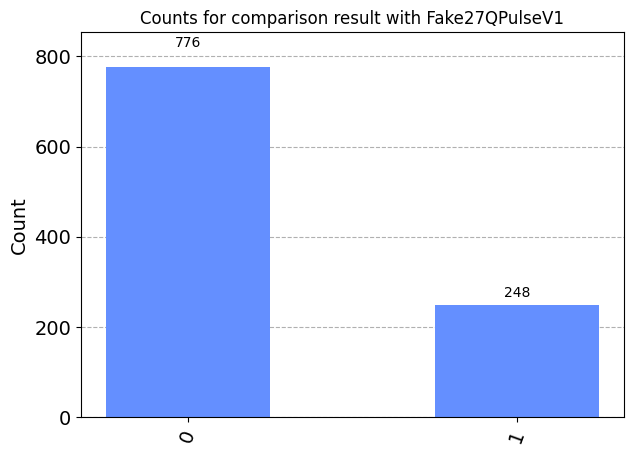

In [10]:
from qiskit.providers.fake_provider import Fake27QPulseV1
device_backend = Fake27QPulseV1()
_,counts=less_than(device_backend,15,15,shots=1024)
plot_histogram(counts, title="Counts for comparison result with Fake27QPulseV1")

### 2.1 Fake127QPulseV1

A fake pulse backend with the following characteristics:
- num_qubits: 127
- coupling_map: heavy-hex based
- basis_gates: ["id", "rz", "sx", "x", "cx", "reset"]

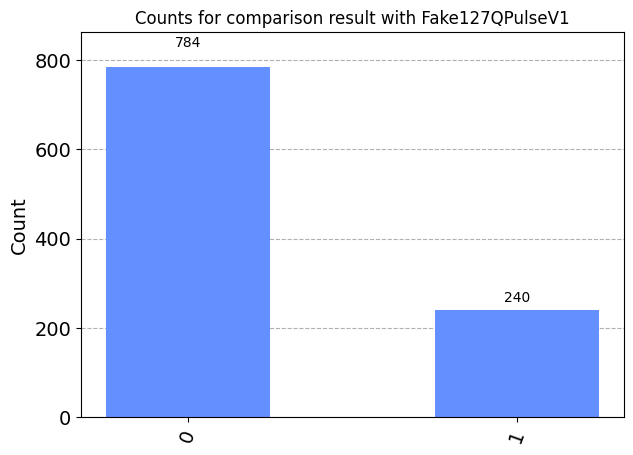

In [11]:
from qiskit.providers.fake_provider import Fake127QPulseV1
device_backend = Fake127QPulseV1()
_,counts=less_than(device_backend,15,15,shots=1024)
plot_histogram(counts, title="Counts for comparison result with Fake127QPulseV1")

In [12]:
prob_list=[]
numDigit_list=[]
for i in tqdm(range(1,7)):
    print("running setup with binary number of {} digits...".format(i))
    num=2**i-1
    _,counts=less_than(device_backend,num,num,shots=1024)
    
    prob_list.append(counts['0']/(counts['0']+counts['1']))
    numDigit_list.append(i)
print("All done!")

  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

running setup with binary number of 1 digits...


 17%|████████████████████████▏                                                                                                                        | 1/6 [00:01<00:08,  1.64s/it]

running setup with binary number of 2 digits...


 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:03<00:06,  1.56s/it]

running setup with binary number of 3 digits...


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:05<00:06,  2.14s/it]

running setup with binary number of 4 digits...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:13<00:08,  4.20s/it]

running setup with binary number of 5 digits...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [02:51<00:59, 59.71s/it]

running setup with binary number of 6 digits...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [35:54<00:00, 359.08s/it]

All done!


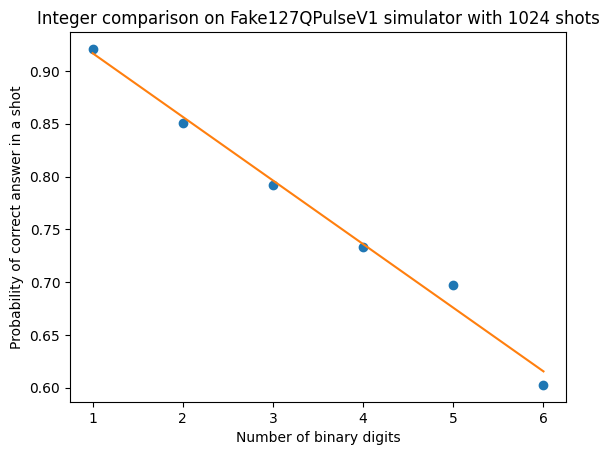

In [13]:
plt.plot(numDigit_list, prob_list, 'o')
a, b = np.polyfit(numDigit_list, prob_list, 1)
plt.plot(numDigit_list, a*np.array(numDigit_list)+b)
plt.title("Integer comparison on Fake127QPulseV1 simulator with 1024 shots")
plt.xlabel("Number of binary digits")
plt.ylabel("Probability of correct answer in a shot")
plt.show()

The noise becomes much more significant as the number of binary digits increases. However, with sufficient number of shots and not too large (or not too negative) integers, the answer could still be computed with confidence. Note that the probability of obtaining a correct answer in the plot above is the probability in one shot. 

- If one performs 1000 shot and the chance of getting the correct answer is only 60%, this means we have 600 shots returning the correct answer with a statistical uncertainty of sqrt(600). This is far above the 50% random guess.

If the list of integers becomes long, the chance of making at least one mistake could increase quickly with the list length $N$:
$\textrm{Prob}\left(\ge\textrm{1 mistake}\right)=1-\left(\textrm{Prob}(\textrm{correct})\right)^N$
- At a rough estimation, even if the list grows to 1000 numbers, the algorithm should still be robust with 3$\sigma$ confidence.

When the number of binary digits increases, the processing time of the simulator also increased exponentially.

It would be interesting to study how zero-noise extrapolation might help mitigating the noise. (It was attempted to use mitiq to apply ZNE; however, there was some issues when the QuantumCircuit was being converted into a mitiq circuit object) 